In [35]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [36]:
def generate_ellipsoid_data(n_points= 205, x_length= 30, y_width= 18, z_height= 4):
    """
    Description:
        This function generates random points uniformly distributed within an ellipsoid
        defined by the semi-axis lengths x_length, y_width and z_height
        the synthetic data generated will serve as a good visualization
        for the PCA algorithm results in 2D
    Args:
        n_points: Number of points generated inside the ellipsoid
        length: length of the semi-axis along the x-dimension
        width: width of the semi-axis along the y-dimension
        height: height of the semi-axis along the z-dimension
    Returns:
        A tensor of shape (n_points, 3) containing the 3D coordinates of points
        uniformly distributed within the ellipsoid
    """
    # Generate random angles and radius for spherical coords
    phi= torch.rand(n_points) * 2 * torch.pi # Azimuthal angle [0, 2pi]
    costheta= torch.rand(n_points) * 2 - 1 # Cosine of polar angle [-1, 1]
    u= torch.rand(n_points) # Uniform random var [0, 1]

    # Convert to polar angle from its cosine
    theta= torch.acos(costheta)

    # Apply cube root to ensure uniform distribution within the sphere volume
    r= u ** (1/3)

    # Convert spherical coords to Cartesian coordinates
    x= r * torch.sin(theta) * torch.cos(phi)
    y= r * torch.sin(theta) * torch.sin(phi)
    z= r * torch.cos(theta)

    # Scale coordinates to form an ellipsoid with dimensions (a, b, c)
    x= x * x_length
    y= y * y_width
    z= z * z_height

    return torch.stack([x, y, z], dim= 1)


In [37]:
n_samples= 6000
length= 60
width= 45
height= 20

ellipsoid_data= generate_ellipsoid_data(n_samples, length, width, height)


# Principal Component Analysis using Singular Value Decomposition

## Overview
Principal Component Analysis (PCA) is a dimensionality reduction technique that identifies patterns in data by transforming it into a new coordinate system where the greatest variance lies on the first coordinate (first principal component), the second greatest variance on the second coordinate, and so on.

## Mathematical Foundation

### Step 1: Data Centering
Given a data matrix $X$ of shape $(n \times d)$ where:
- $n$ = number of samples
- $d$ = number of features

We first center the data by subtracting the mean of each feature:
$X_{\text{centered}} = X - \bar{X}$
where $\bar{X}$ is the mean vector of shape $(1 \times d)$.

### Step 2: Singular Value Decomposition (SVD)
We apply SVD to the centered data matrix:
$X_{\text{centered}} = U \Sigma V^T$
where:
- $U$ is an $n \times n$ orthogonal matrix (left singular vectors)
- $\Sigma$ is an $n \times d$ diagonal matrix with singular values $\sigma_i$ on the diagonal
- $V^T$ is a $d \times d$ orthogonal matrix (right singular vectors, transposed)

The columns of $V$ (rows of $V^T$) are the principal components of the data.

### Step 3: Dimensionality Reduction
To reduce the data to $k$ dimensions (where $k < d$):
1. Select the first $k$ columns of $U$: $U_k$ (shape $n \times k$)
2. Select the first $k$ singular values: $\Sigma_k$ (shape $k \times k$)
3. Compute the reduced data:
   $X_{\text{reduced}} = U_k \Sigma_k$

This is equivalent to projecting the centered data onto the first $k$ principal components:
$X_{\text{reduced}} = X_{\text{centered}} V_k$
where $V_k$ contains the first $k$ columns of $V$.

## Why SVD is Used for PCA

1. **Numerical Stability**: SVD is more numerically stable than computing the covariance matrix and its eigendecomposition, especially for ill-conditioned matrices.

2. **Efficiency**: For datasets where $n \gg d$ or $d \gg n$, SVD can be more efficient than eigendecomposition of the covariance matrix.

3. **Direct Computation**: SVD directly provides all the necessary components:
   - Principal components (columns of $V$)
   - Projected data ($U \Sigma$)

4. **Avoids Explicit Covariance Calculation**: Computing $X^T X$ explicitly can lead to numerical precision issues, which SVD avoids.

## Relationship to Covariance Matrix

The covariance matrix of the centered data is:
$C = \frac{1}{n-1} X_{\text{centered}}^T X_{\text{centered}}$

Using the SVD decomposition:
$C = \frac{1}{n-1} V \Sigma^T U^T U \Sigma V^T = \frac{1}{n-1} V \Sigma^2 V^T$

This shows that:
- The eigenvectors of $C$ are the right singular vectors $V$
- The eigenvalues of $C$ are $\frac{\sigma_i^2}{n-1}$

## Implementation Notes

The implementation uses the efficient computation:
$X_{\text{reduced}} = U_k \Sigma_k$
which is equivalent to:
$X_{\text{reduced}} = X_{\text{centered}} V_k$

This avoids explicitly computing the matrix multiplication and leverages the properties of SVD for numerical stability and efficiency.

In [ ]:
def principle_component_analysis(data, n_components= 2):
    """
    Description:
        Perform Principal Component Analysis (PCA) using Singular Value Decomposition (SVD).
        
        This function reduces the dimensionality of the input data by projecting it onto 
        the principal components that capture the maximum variance in the data.
        
    Args:
        data : torch.Tensor
            Input data tensor of shape (n_samples, n_features) where:
            - n_samples is the number of observations
            - n_features is the number of features/dimensions
        dimensions_out : int, optional (default=2)
            Number of dimensions to reduce the data to. Must be less than or equal to n_features.
        
    Returns:
        torch.Tensor
            Reduced data tensor of shape (n_samples, dimensions_out) containing the 
            transformed data in the new coordinate system defined by the principal components.
        
    Notes:
        - The data is centered by subtracting the mean of each feature before applying SVD.
        - The implementation uses the SVD approach which is numerically stable and efficient.
        - The principal components are ordered by the amount of variance they explain in descending order.
        - The reduced data is computed as the product of the left singular vectors and singular values.
    """
    mean= torch.mean(data, axis= 0)
    data_centered= data - mean

    U, S, Vt= torch.linalg.svd(data_centered, full_matrices= False)

    data_reduced= U[:, :n_components] * S[:n_components]
    return data_reduced

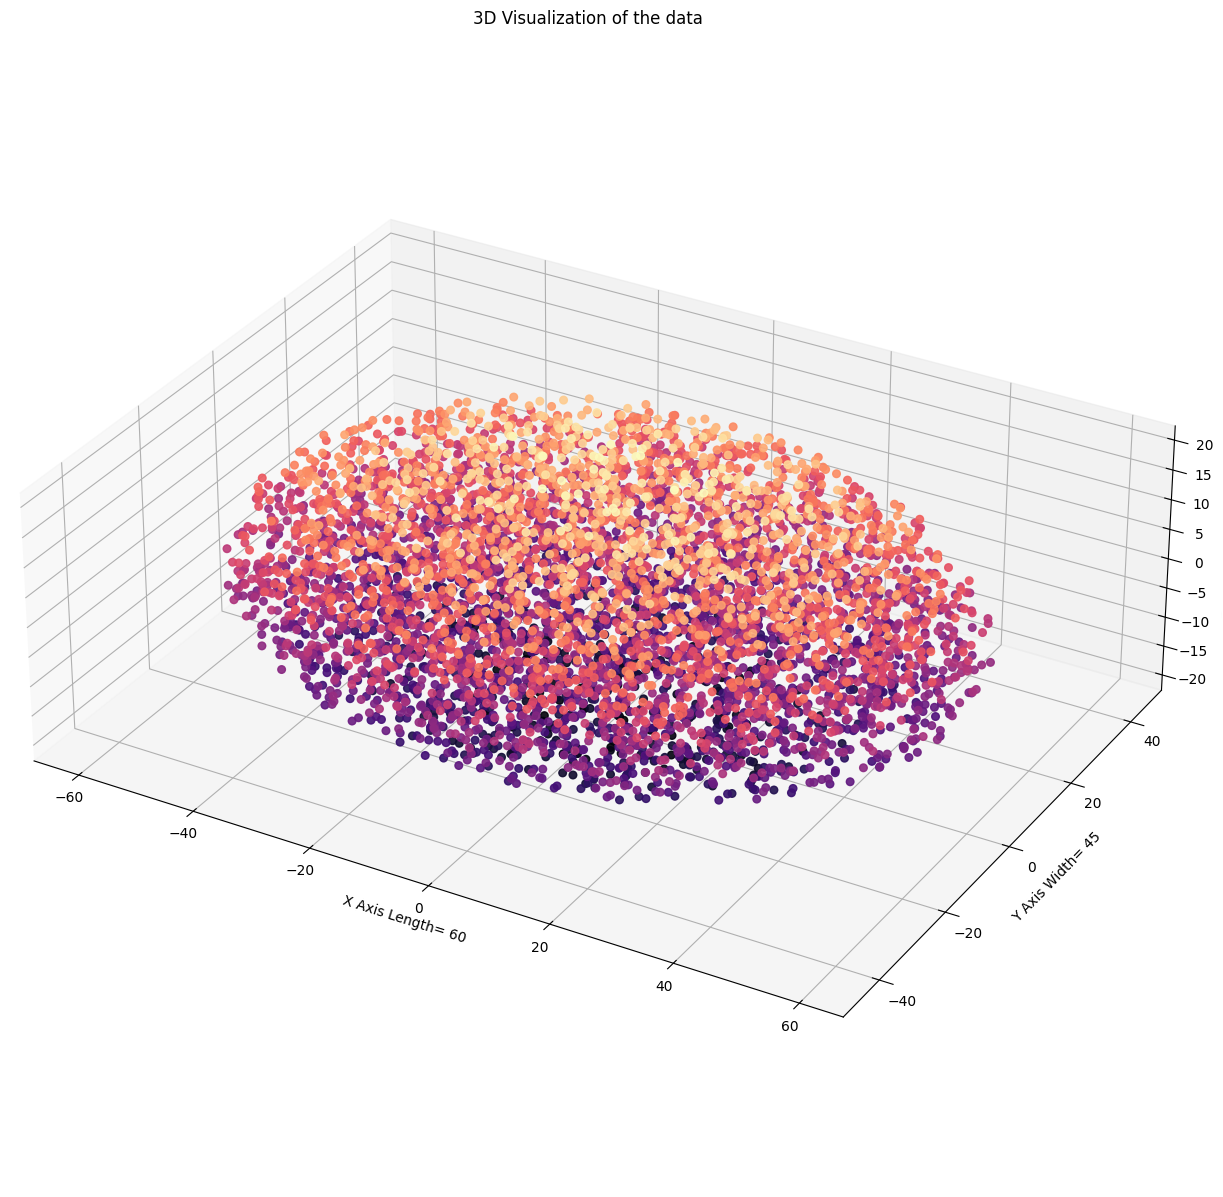

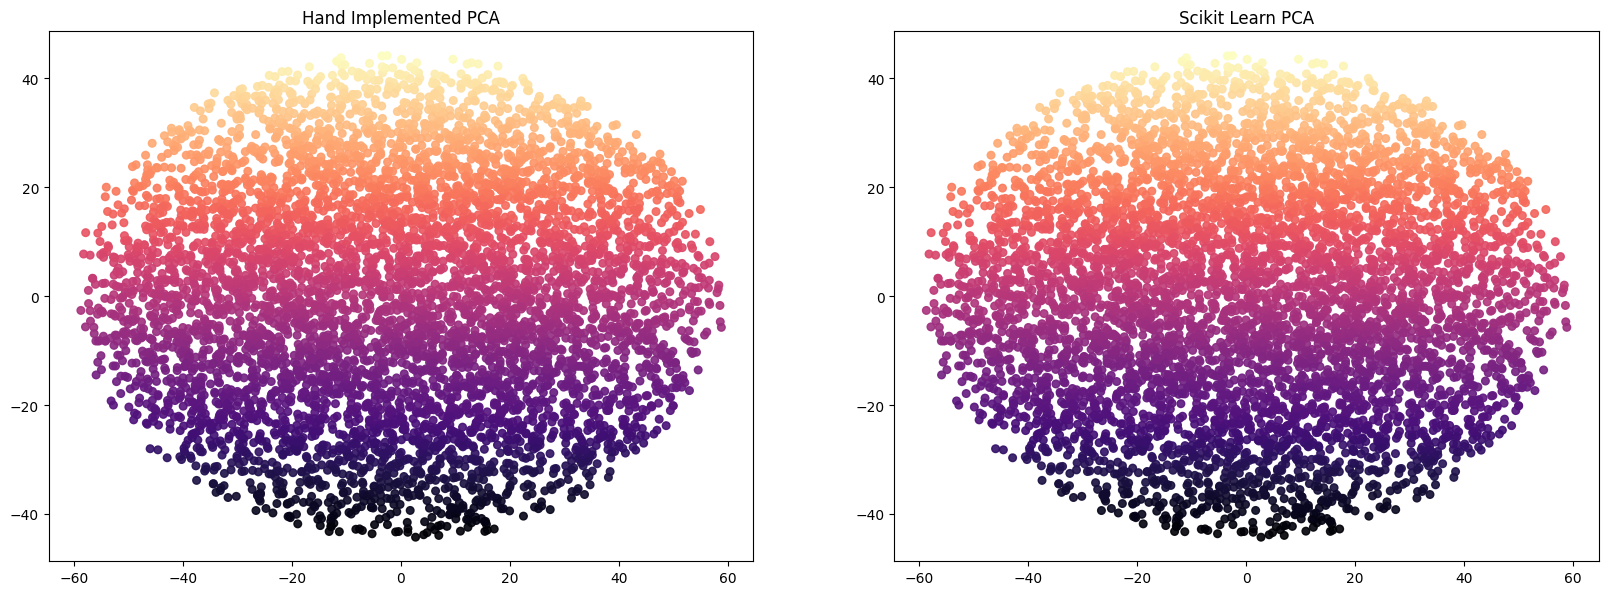

In [40]:
ellipsoid_data_reduced= principle_component_analysis(ellipsoid_data)


# Create a 3D scatter plot
fig= plt.figure(figsize= (20, 15))
ax1= fig.add_subplot(111, projection= '3d')

# Extract x, y, z Coords
x= ellipsoid_data[:, 0].numpy()
y= ellipsoid_data[:, 1].numpy()
z= ellipsoid_data[:, 2].numpy()

# Plot the points
scatter= ax1.scatter(x, y, z, c= z, cmap= 'magma', alpha= 0.9, s= 30)
ax1.set_aspect('equal', adjustable= 'box')

# Set labels and title
ax1.set_title("3D Visualization of the data")
ax1.set_xlabel(f'X Axis Length= {length}')
ax1.set_ylabel(f'Y Axis Width= {width}')
ax1.set_zlabel(f'Z Axis Height= {height}')

fig2= plt.figure(figsize= (20, 10))
x_2d= ellipsoid_data_reduced[:, 0].numpy()
y_2d= ellipsoid_data_reduced[:, 1].numpy()

ax2= fig2.add_subplot(121)
ax2.set_title("Hand Implemented PCA")
scatter= ax2.scatter(x_2d, y_2d, c= y_2d, cmap= 'magma', alpha= 0.9, s= 30)
ax2.set_aspect('equal', adjustable= 'box')
# Sanity check using PCA from sklearn
pca= PCA(n_components= 2)
data_sklearn_reduced= pca.fit(ellipsoid_data)
x_2d= ellipsoid_data_reduced[:, 0].numpy()
y_2d= ellipsoid_data_reduced[:, 1].numpy()

ax3= fig2.add_subplot(122)
ax3.set_title("Scikit Learn PCA")
scatter= ax3.scatter(x_2d, y_2d, c= y_2d, cmap= 'magma', alpha= 0.9, s= 30)
ax3.set_aspect('equal', adjustable= 'box')

